In [2]:
# Install required packages
!pip install -q keras-tuner shap category_encoders
print('Packages installed (or already present).')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.2 MB/s eta 0:00:00
Packages installed (or already present).


In [4]:
import os, math, gc
import numpy as np, pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, roc_auc_score, log_loss, accuracy_score

# Use on_bad_lines='skip' to skip the problematic line
train = pd.read_csv('/content/xy_train.csv', on_bad_lines='skip')
test  = pd.read_csv('/content/x_test.csv')
sample_submission = pd.read_csv('/content/sample_submission.csv')

# Auto-detect target
target_candidates = [c for c in train.columns if c.lower() in ('target','label','y')]
target = target_candidates[0] if target_candidates else train.columns[-1]
y_series = train[target]
if (y_series.dtype.kind in 'f' and y_series.nunique()>20):
    problem_type='regression'
elif y_series.nunique()==2:
    problem_type='binary'
elif 2<y_series.nunique()<=20:
    problem_type='multiclass'
else:
    problem_type='regression'

print('Target:', target)
print('Problem type:', problem_type)
print('train.shape', train.shape, 'test.shape', test.shape)

Target: label
Problem type: multiclass
train.shape (48000, 3) test.shape (11955, 2)


In [5]:
# Preprocessing: numeric impute + indicators, categorical top-K mapping, scaling
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
if target in num_cols: num_cols.remove(target)
cat_cols = [c for c in train.columns if c not in num_cols+[target] and train[c].dtype=='object']

print('Numeric cols:', len(num_cols), 'Categorical cols:', len(cat_cols))

train_tf = train.copy(); test_tf = test.copy()

# Numeric imputation + indicator
for c in num_cols:
    med = train_tf[c].median()
    train_tf[c].fillna(med, inplace=True)
    test_tf[c].fillna(med, inplace=True)
    train_tf[c + '_nan'] = train[c].isna().astype(int)
    test_tf[c + '_nan'] = test[c].isna().astype(int)

num_cols_ext = num_cols + [c + '_nan' for c in num_cols]

# Categorical: top-K cap and mapping
TOPK = 10000
cat_maps = {}
cat_cardinalities = {}
for c in cat_cols:
    train_tf[c] = train_tf[c].fillna('___missing___').astype(str)
    test_tf[c]  = test_tf[c].fillna('___missing___').astype(str)
    vc = train_tf[c].value_counts()
    if len(vc) > TOPK:
        keep = set(vc.index[:TOPK])
        train_tf[c] = train_tf[c].apply(lambda x: x if x in keep else '__other__')
        test_tf[c]  = test_tf[c].apply(lambda x: x if x in keep else '__other__')
        vc = train_tf[c].value_counts()
    uniq = list(vc.index)
    mapping = {k:i+1 for i,k in enumerate(uniq)}  # reserve 0 for unknown
    mapping['__other__'] = 0
    cat_maps[c] = mapping
    cat_cardinalities[c] = max(1, len(mapping))

# Apply mapping arrays
if len(cat_cols) > 0:
    X_cat_train = np.stack([train_tf[c].map(lambda x: cat_maps[c].get(x,0)).astype(np.int32).values for c in cat_cols], axis=1)
    X_cat_test  = np.stack([test_tf[c].map(lambda x: cat_maps[c].get(x,0)).astype(np.int32).values for c in cat_cols], axis=1)
else:
    X_cat_train = np.zeros((len(train_tf),0), dtype=np.int32)
    X_cat_test  = np.zeros((len(test_tf),0), dtype=np.int32)

# Scale numeric features
scaler = StandardScaler()
X_num_train = scaler.fit_transform(train_tf[num_cols_ext].astype(float).values)
X_num_test  = scaler.transform(test_tf[num_cols_ext].astype(float).values)

y = train_tf[target].values

print('Shapes -> X_num:', X_num_train.shape, 'X_cat:', X_cat_train.shape)

Numeric cols: 1 Categorical cols: 1
Shapes -> X_num: (48000, 2) X_cat: (48000, 1)


/tmp/ipython-input-4186526252.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_tf[c].fillna(med, inplace=True)
/tmp/ipython-input-4186526252.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

In [6]:
# Leakage-safe target encoding (CV-based)
from sklearn.model_selection import KFold, StratifiedKFold

def target_encode_cv(train_df, test_df, col, target_col, n_splits=5, problem_type='regression', smoothing=0.3):
    te_vals = np.zeros(len(train_df))
    global_mean = train_df[target_col].mean()
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42) if (problem_type!='regression' and train_df[target_col].nunique()>1) else KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for tr_idx, val_idx in kf.split(train_df, train_df[target_col] if problem_type!='regression' else None):
        grp = train_df.iloc[tr_idx].groupby(col)[target_col].agg(['mean','count'])
        smooth = (grp['count'] * grp['mean'] + smoothing * global_mean) / (grp['count'] + smoothing)
        mapping = smooth.to_dict()
        te_vals[val_idx] = train_df.iloc[val_idx][col].map(mapping).fillna(global_mean).values
    full_grp = train_df.groupby(col)[target_col].agg(['mean','count'])
    smooth_full = (full_grp['count'] * full_grp['mean'] + smoothing * global_mean) / (full_grp['count'] + smoothing)
    test_enc = test_df[col].map(smooth_full.to_dict()).fillna(global_mean).values
    return te_vals, test_enc

# Toggle target encoding here (limit number of columns to avoid slowdown)
apply_te = True
if apply_te and len(cat_cols) > 0:
    te_cols = cat_cols[:2]  # adjust as needed
    for c in te_cols:
        print('Applying TE to', c)
        tr_enc, te_enc = target_encode_cv(train_tf, test_tf, c, target, n_splits=5, problem_type=problem_type)
        X_num_train = np.hstack([X_num_train, tr_enc.reshape(-1,1)])
        X_num_test  = np.hstack([X_num_test, te_enc.reshape(-1,1)])
    print('New numeric shape:', X_num_train.shape)

Applying TE to text
New numeric shape: (48000, 3)


In [7]:
# tf.data dataset helpers with numeric noise augmentation
import tensorflow as tf

def make_dataset(X_num, X_cat, y=None, batch_size=256, shuffle=False, augment=False, noise_std=0.01):
    ds_num = tf.data.Dataset.from_tensor_slices(X_num.astype('float32'))
    ds_cat = tf.data.Dataset.from_tensor_slices(X_cat.astype('int32'))
    if y is not None:
        ds_y = tf.data.Dataset.from_tensor_slices(y)
        ds = tf.data.Dataset.zip((ds_num, ds_cat, ds_y))
    else:
        ds = tf.data.Dataset.zip((ds_num, ds_cat))
    if shuffle and y is not None:
        ds = ds.shuffle(buffer_size=len(X_num), seed=42)
    def pack(num, cat, lab=None):
        if y is not None:
            if augment:
                num = num + tf.random.normal(tf.shape(num), stddev=noise_std)
            return ({'num': num, 'cat': cat}, lab)
        else:
            return ({'num': num, 'cat': cat})
    if y is not None:
        ds = ds.map(pack, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds = ds.map(lambda num,cat: ({'num': num, 'cat': cat}), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [11]:
# Advanced model builder: embeddings + transformer blocks + MLP head
# import tensorflow_addons as tfa # Removed tensorflow_addons import

def transformer_block(x, num_heads=4, key_dim=32, ff_dim=128, dropout=0.1, l2_reg=1e-5):
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    attn = layers.Dropout(dropout)(attn)
    out1 = layers.LayerNormalization(epsilon=1e-6)(x + attn)
    ff = layers.Dense(ff_dim, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg))(out1)
    ff = layers.Dense(out1.shape[-1], kernel_regularizer=keras.regularizers.l2(l2_reg))(ff)
    ff = layers.Dropout(dropout)(ff)
    return layers.LayerNormalization(epsilon=1e-6)(out1 + ff)

def build_advanced_model(cat_cardinalities, num_input_dim,
                         emb_dropout=0.12, embed_dim_rule='sqrt',
                         n_transformer_blocks=2, num_heads=4, key_dim=32, ff_dim=128,
                         mlp_units=[512,256], mlp_dropout=0.2, l2_reg=1e-5):
    num_in = layers.Input(shape=(num_input_dim,), name='num', dtype=tf.float32)
    cat_in = layers.Input(shape=(len(cat_cardinalities),), name='cat', dtype=tf.int32)

    embeds = []
    for i,(col,card) in enumerate(cat_cardinalities.items()):
        if embed_dim_rule == 'sqrt':
            emb_dim = max(4, int(min(50, math.sqrt(card))))
        elif isinstance(embed_dim_rule, int):
            emb_dim = embed_dim_rule
        else:
            emb_dim = max(4, int(min(50, math.sqrt(card))))
        slice_i = layers.Lambda(lambda x, i=i: x[:, i:i+1])(cat_in)
        e = layers.Embedding(input_dim=card+1, output_dim=emb_dim,
                             embeddings_regularizer=keras.regularizers.l2(l2_reg))(slice_i)
        e = layers.Reshape((emb_dim,))(e)
        embeds.append(e)
    if len(embeds) > 0:
        cat_embed = layers.Concatenate()(embeds)
        cat_embed = layers.Dropout(emb_dropout)(cat_embed)
    else:
        cat_embed = None

    num_branch = layers.LayerNormalization()(num_in)
    num_branch = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg))(num_branch)
    num_branch = layers.Dropout(mlp_dropout)(num_branch)

    if cat_embed is not None:
        num_token = layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg))(num_branch)
        split_tokens = []
        total_dim = int(cat_embed.shape[-1])
        n_cat = len(embeds)
        per = max(1, total_dim // n_cat)
        for i in range(n_cat):
            start = i*per
            end = start + per if i < n_cat-1 else total_dim
            token = layers.Lambda(lambda x, s=start, e=end: x[:, s:e])(cat_embed)
            token = layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg))(token)
            split_tokens.append(layers.Reshape((1, int(token.shape[-1])))(token))
        tokens = [layers.Reshape((1, int(num_token.shape[-1])))(num_token)] + split_tokens
        seq = layers.Concatenate(axis=1)(tokens)
    else:
        seq = layers.Reshape((1, int(num_branch.shape[-1])))(num_branch)

    x = seq
    for _ in range(n_transformer_blocks):
        x = transformer_block(x, num_heads=num_heads, key_dim=key_dim, ff_dim=ff_dim, dropout=mlp_dropout, l2_reg=l2_reg)

    x = layers.GlobalAveragePooling1D()(x)

    if cat_embed is not None:
        h = layers.Concatenate()([x, num_branch, cat_embed])
    else:
        h = layers.Concatenate()([x, num_branch])

    for u in mlp_units:
        h = layers.Dense(u, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
        h = layers.LayerNormalization()(h)
        h = layers.Dropout(mlp_dropout)(h)

    if problem_type == 'regression':
        out = layers.Dense(1, dtype='float32', name='out')(h)
        loss = 'mse'; metrics=[keras.metrics.RootMeanSquaredError()]
    elif problem_type == 'binary':
        out = layers.Dense(1, activation='sigmoid', dtype='float32', name='out')(h)
        loss = 'binary_crossentropy'; metrics=[keras.metrics.AUC()]
    else:
        n_classes = int(np.unique(y).shape[0])
        out = layers.Dense(n_classes, activation='softmax', dtype='float32', name='out')(h)
        loss = 'sparse_categorical_crossentropy'; metrics=['sparse_categorical_accuracy']

    model = keras.Model(inputs=[num_in, cat_in], outputs=out)
    # try:
    #     opt = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)
    # except Exception:
    opt = keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    return model

In [12]:
# Quick demo build to ensure model compiles
model = build_advanced_model(cat_cardinalities, X_num_train.shape[1],
                             emb_dropout=0.12, embed_dim_rule='sqrt',
                             n_transformer_blocks=1, num_heads=2, key_dim=32, ff_dim=64,
                             mlp_units=[256,128], mlp_dropout=0.15, l2_reg=1e-5)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cat (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ cat[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 50)     │    500,100 │ lambda[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num (InputLayer)    │ (None, 3)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 3)         │          6 │ num[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 50)        │          0 │ reshape[0][0]     │
│ (Concatenate)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │        512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 50)        │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 50)        │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      3,264 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 64)     │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 64)     │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 2, 64)     │          0 │ reshape_2[0][0],  │
│ (Concatenate)       │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2, 64)     │     16,640 │ concatenate_1[0]… │
│ (MultiHeadAttentio… │                   │            │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 2, 64)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 2, 64)     │          0 │ concatenate_1[0]… │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2, 64)     │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2, 64)     │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 633,613 (2.42 MB)

 Trainable params: 633,613 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Quick K-Fold smoke test (small folds/epochs)
N_FOLDS = 3
BATCH_SIZE = 256
EPOCHS = 8

kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42) if (problem_type!='regression') else KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

oof = np.zeros((len(X_num_train),) if problem_type!='multiclass' else (len(X_num_train), int(np.unique(y).shape[0])))
test_pred = np.zeros((len(X_num_test),) if problem_type!='multiclass' else (len(X_num_test), int(np.unique(y).shape[0])))

for fold, (tr, val) in enumerate(kf.split(X_num_train, y if problem_type!='regression' else None)):
    print('\nFold', fold+1)
    Xn_tr, Xn_val = X_num_train[tr], X_num_train[val]
    Xc_tr, Xc_val = X_cat_train[tr], X_cat_train[val]
    y_tr, y_val = y[tr], y[val]

    ds_tr = make_dataset(Xn_tr, Xc_tr, y_tr, batch_size=BATCH_SIZE, shuffle=True, augment=True)
    ds_val = make_dataset(Xn_val, Xc_val, y_val, batch_size=BATCH_SIZE, shuffle=False)

    model = build_advanced_model(cat_cardinalities, X_num_train.shape[1],
                                 emb_dropout=0.12, embed_dim_rule='sqrt',
                                 n_transformer_blocks=1, num_heads=2, key_dim=32, ff_dim=64,
                                 mlp_units=[256,128], mlp_dropout=0.15, l2_reg=1e-5)
    ckpt = f'quick_fold_{fold+1}.h5'
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1),
        tf.keras.callbacks.ModelCheckpoint(ckpt, save_best_only=True, monitor='val_loss', verbose=0)
    ]
    history = model.fit(ds_tr, validation_data=ds_val, epochs=EPOCHS, callbacks=callbacks, verbose=2)
    val_preds = model.predict(make_dataset(Xn_val, Xc_val, y=None, batch_size=512), verbose=0)
    if problem_type == 'multiclass':
        oof[val] = val_preds
    else:
        oof[val] = val_preds.reshape(-1)
    test_fold = model.predict(make_dataset(X_num_test, X_cat_test, y=None, batch_size=512), verbose=0)
    if problem_type == 'multiclass':
        test_pred += test_fold / N_FOLDS
    else:
        test_pred += test_fold.reshape(-1) / N_FOLDS

if problem_type == 'regression':
    print('Quick CV RMSE:', mean_squared_error(y, oof, squared=False))
elif problem_type == 'binary':
    print('Quick CV AUC:', roc_auc_score(y, oof))
else:
    print('Quick CV logloss:', log_loss(y, oof), 'acc:', accuracy_score(y, np.argmax(oof, axis=1)))


Fold 1
Epoch 1/8


125/125 - 19s - 156ms/step - loss: 0.7735 - sparse_categorical_accuracy: 0.5095 - val_loss: 0.7275 - val_sparse_categorical_accuracy: 0.4669 - learning_rate: 1.0000e-03
Epoch 2/8


125/125 - 6s - 49ms/step - loss: 0.7290 - sparse_categorical_accuracy: 0.5235 - val_loss: 0.7218 - val_sparse_categorical_accuracy: 0.5376 - learning_rate: 1.0000e-03
Epoch 3/8
125/125 - 10s - 82ms/step - loss: 0.6460 - sparse_categorical_accuracy: 0.5932 - val_loss: 0.7646 - val_sparse_categorical_accuracy: 0.5394 - learning_rate: 1.0000e-03
Epoch 4/8

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
125/125 - 8s - 62ms/step - loss: 0.5817 - sparse_categorical_accuracy: 0.6224 - val_loss: 1.0857 - val_sparse_categorical_accuracy: 0.5394 - learning_rate: 1.0000e-03
Epoch 5/8
125/125 - 9s - 69ms/step - loss: 0.5760 - sparse_categorical_accuracy: 0.6274 - val_loss: 1.0787 - val_sparse_categorical_accuracy: 0.4283 - learning_rate: 5.0000e-04
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.

Fold 2
Epoch 1/8


125/125 - 17s - 136ms/step - loss: 0.7868 - sparse_categorical_accuracy: 0.5081 - val_loss: 0.7265 - val_sparse_categorical_accuracy: 0.5375 - learning_rate: 1.0000e-03
Epoch 2/8


125/125 - 6s - 50ms/step - loss: 0.7326 - sparse_categorical_accuracy: 0.5163 - val_loss: 0.7209 - val_sparse_categorical_accuracy: 0.5375 - learning_rate: 1.0000e-03
Epoch 3/8
125/125 - 10s - 83ms/step - loss: 0.7181 - sparse_categorical_accuracy: 0.5358 - val_loss: 0.7443 - val_sparse_categorical_accuracy: 0.5209 - learning_rate: 1.0000e-03
Epoch 4/8

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
125/125 - 8s - 62ms/step - loss: 0.6085 - sparse_categorical_accuracy: 0.6095 - val_loss: 0.8509 - val_sparse_categorical_accuracy: 0.5400 - learning_rate: 1.0000e-03
Epoch 5/8
125/125 - 6s - 49ms/step - loss: 0.5790 - sparse_categorical_accuracy: 0.6252 - val_loss: 0.8825 - val_sparse_categorical_accuracy: 0.5400 - learning_rate: 5.0000e-04
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.

Fold 3
Epoch 1/8


125/125 - 15s - 120ms/step - loss: 0.7914 - sparse_categorical_accuracy: 0.5084 - val_loss: 0.7210 - val_sparse_categorical_accuracy: 0.5374 - learning_rate: 1.0000e-03
Epoch 2/8
125/125 - 10s - 78ms/step - loss: 0.7312 - sparse_categorical_accuracy: 0.5174 - val_loss: 0.7211 - val_sparse_categorical_accuracy: 0.5374 - learning_rate: 1.0000e-03
Epoch 3/8
125/125 - 8s - 66ms/step - loss: 0.6888 - sparse_categorical_accuracy: 0.5650 - val_loss: 0.7467 - val_sparse_categorical_accuracy: 0.5236 - learning_rate: 1.0000e-03
Epoch 4/8
125/125 - 6s - 49ms/step - loss: 0.5915 - sparse_categorical_accuracy: 0.6157 - val_loss: 0.8736 - val_sparse_categorical_accuracy: 0.5238 - learning_rate: 5.0000e-04
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
Quick CV logloss: 0.7136496808206424 acc: 0.5375


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [15]:
# Keras-Tuner (small budget example)
import keras_tuner as kt
from sklearn.model_selection import train_test_split

class AdvancedHyperModel(kt.HyperModel):
    def build(self, hp):
        n_blocks = hp.Int('n_blocks', 1, 2)
        heads = hp.Choice('heads', [2,4])
        ff_dim = hp.Choice('ff_dim', [64,128])
        mlp1 = hp.Int('mlp1', 128, 384, step=128)
        drop = hp.Float('drop', 0.0, 0.3, step=0.05)
        return build_advanced_model(cat_cardinalities, X_num_train.shape[1],
                                    emb_dropout=hp.Float('emb_drop', 0.0, 0.2),
                                    n_transformer_blocks=n_blocks, num_heads=heads, key_dim=32, ff_dim=ff_dim,
                                    mlp_units=[mlp1, max(64, mlp1//2)], mlp_dropout=drop, l2_reg=1e-5)

tuner = kt.RandomSearch(AdvancedHyperModel(), objective='val_loss', max_trials=4, executions_per_trial=1, directory='kt_dir', project_name='tf_adv')
SUBSET = min(5000, len(X_num_train))

# Split data into training and validation sets
Xn_train_sub, Xn_val_sub, Xc_train_sub, Xc_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_num_train[:SUBSET], X_cat_train[:SUBSET], y[:SUBSET], test_size=0.2, random_state=42
)

# Create tf.data datasets for training and validation
ds_tr = make_dataset(Xn_train_sub, Xc_train_sub, y_train_sub, shuffle=True)
ds_val = make_dataset(Xn_val_sub, Xc_val_sub, y_val_sub, shuffle=False)


tuner.search(ds_tr, epochs=6, validation_data=ds_val)
print('Best hyperparameters:', tuner.get_best_hyperparameters(1)[0].values)

Trial 4 Complete [00h 00m 23s]
val_loss: 0.7056900262832642

Best val_loss So Far: 0.7050557732582092
Total elapsed time: 00h 01m 34s
Best hyperparameters: {'n_blocks': 2, 'heads': 4, 'ff_dim': 64, 'mlp1': 384, 'drop': 0.15000000000000002, 'emb_drop': 0.19439959418277064}


In [16]:
# Final training using tuner results (if available), otherwise defaults
try:
    best_hp = tuner.get_best_hyperparameters(1)[0]
    n_blocks = best_hp.get('n_blocks'); heads = best_hp.get('heads'); ff_dim = best_hp.get('ff_dim')
    mlp1 = best_hp.get('mlp1'); drop = best_hp.get('drop'); emb_drop = best_hp.get('emb_drop')
    mlp_units = [mlp1, max(64, mlp1//2)]
    n_transformer_blocks = n_blocks; num_heads = heads; key_dim = 32; mlp_dropout = drop; emb_dropout = emb_drop
    print('Using tuner hyperparams:', best_hp.values)
except Exception as e:
    print('No tuner results, using defaults'); n_transformer_blocks=2; num_heads=4; key_dim=32; ff_dim=128; mlp_units=[512,256]; mlp_dropout=0.2; emb_dropout=0.12

N_FOLDS = 5
BATCH_SIZE = 256
EPOCHS = 50
kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42) if (problem_type!='regression') else KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

oof_final = np.zeros((len(X_num_train),) if problem_type!='multiclass' else (len(X_num_train), int(np.unique(y).shape[0])))
test_final = np.zeros((len(X_num_test),) if problem_type!='multiclass' else (len(X_num_test), int(np.unique(y).shape[0])))

for fold, (tr, val) in enumerate(kf.split(X_num_train, y if problem_type!='regression' else None)):
    print('\nFinal Fold', fold+1)
    Xn_tr, Xn_val = X_num_train[tr], X_num_train[val]
    Xc_tr, Xc_val = X_cat_train[tr], X_cat_train[val]
    y_tr, y_val = y[tr], y[val]

    ds_tr = make_dataset(Xn_tr, Xc_tr, y_tr, batch_size=BATCH_SIZE, shuffle=True, augment=True)
    ds_val = make_dataset(Xn_val, Xc_val, y_val, batch_size=BATCH_SIZE, shuffle=False)
    ds_test = make_dataset(X_num_test, X_cat_test, y=None, batch_size=512, shuffle=False)

    model = build_advanced_model(cat_cardinalities, X_num_train.shape[1],
                                 emb_dropout=emb_dropout, embed_dim_rule='sqrt',
                                 n_transformer_blocks=n_transformer_blocks, num_heads=num_heads, key_dim=key_dim, ff_dim=ff_dim,
                                 mlp_units=mlp_units, mlp_dropout=mlp_dropout, l2_reg=1e-5)

    ckpt = f'final_model_fold_{fold+1}.h5'
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1),
        tf.keras.callbacks.ModelCheckpoint(ckpt, save_best_only=True, monitor='val_loss', verbose=0)
    ]

    history = model.fit(ds_tr, validation_data=ds_val, epochs=EPOCHS, callbacks=callbacks, verbose=2)
    val_preds = model.predict(make_dataset(Xn_val, Xc_val, y=None, batch_size=512), verbose=0)
    if problem_type == 'multiclass':
        oof_final[val] = val_preds
    else:
        oof_final[val] = val_preds.reshape(-1)
    test_fold = model.predict(ds_test, verbose=0)
    if problem_type == 'multiclass':
        test_final += test_fold / N_FOLDS
    else:
        test_final += test_fold.reshape(-1) / N_FOLDS

if problem_type == 'regression':
    print('\nFinal CV RMSE:', mean_squared_error(y, oof_final, squared=False))
elif problem_type == 'binary':
    print('\nFinal CV AUC:', roc_auc_score(y, oof_final))
else:
    print('\nFinal CV logloss:', log_loss(y, oof_final), 'CV acc:', accuracy_score(y, np.argmax(oof_final, axis=1)))

Using tuner hyperparams: {'n_blocks': 2, 'heads': 4, 'ff_dim': 64, 'mlp1': 384, 'drop': 0.15000000000000002, 'emb_drop': 0.19439959418277064}

Final Fold 1
Epoch 1/50


150/150 - 31s - 210ms/step - loss: 0.7723 - sparse_categorical_accuracy: 0.5117 - val_loss: 0.7228 - val_sparse_categorical_accuracy: 0.5375 - learning_rate: 1.0000e-03
Epoch 2/50
150/150 - 16s - 108ms/step - loss: 0.7315 - sparse_categorical_accuracy: 0.5172 - val_loss: 0.7228 - val_sparse_categorical_accuracy: 0.5375 - learning_rate: 1.0000e-03
Epoch 3/50
150/150 - 15s - 102ms/step - loss: 0.6859 - sparse_categorical_accuracy: 0.5646 - val_loss: 0.7344 - val_sparse_categorical_accuracy: 0.5279 - learning_rate: 1.0000e-03
Epoch 4/50


150/150 - 21s - 140ms/step - loss: 0.5882 - sparse_categorical_accuracy: 0.6226 - val_loss: 0.7214 - val_sparse_categorical_accuracy: 0.5392 - learning_rate: 1.0000e-03
Epoch 5/50
150/150 - 20s - 135ms/step - loss: 0.5802 - sparse_categorical_accuracy: 0.6233 - val_loss: 0.9271 - val_sparse_categorical_accuracy: 0.5403 - learning_rate: 1.0000e-03
Epoch 6/50
150/150 - 16s - 104ms/step - loss: 0.5774 - sparse_categorical_accuracy: 0.6237 - val_loss: 0.8025 - val_sparse_categorical_accuracy: 0.5403 - learning_rate: 1.0000e-03
Epoch 7/50

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
150/150 - 21s - 140ms/step - loss: 0.5761 - sparse_categorical_accuracy: 0.6258 - val_loss: 1.0918 - val_sparse_categorical_accuracy: 0.5403 - learning_rate: 1.0000e-03
Epoch 8/50
150/150 - 20s - 130ms/step - loss: 0.5741 - sparse_categorical_accuracy: 0.6271 - val_loss: 0.8641 - val_sparse_categorical_accuracy: 0.5403 - learning_rate: 5.0000e-04
Epoch 9/50
150/150 - 21s - 139ms/s

150/150 - 29s - 192ms/step - loss: 0.7713 - sparse_categorical_accuracy: 0.5084 - val_loss: 0.7238 - val_sparse_categorical_accuracy: 0.5383 - learning_rate: 1.0000e-03
Epoch 2/50
Epoch 3/50


150/150 - 16s - 104ms/step - loss: 0.7271 - sparse_categorical_accuracy: 0.5242 - val_loss: 0.7228 - val_sparse_categorical_accuracy: 0.5392 - learning_rate: 1.0000e-03
Epoch 4/50


150/150 - 17s - 113ms/step - loss: 0.6122 - sparse_categorical_accuracy: 0.6093 - val_loss: 0.7223 - val_sparse_categorical_accuracy: 0.5395 - learning_rate: 1.0000e-03
Epoch 5/50
150/150 - 19s - 128ms/step - loss: 0.5813 - sparse_categorical_accuracy: 0.6265 - val_loss: 1.1390 - val_sparse_categorical_accuracy: 0.5158 - learning_rate: 1.0000e-03
Epoch 6/50
150/150 - 15s - 101ms/step - loss: 0.5767 - sparse_categorical_accuracy: 0.6292 - val_loss: 0.7278 - val_sparse_categorical_accuracy: 0.5385 - learning_rate: 1.0000e-03
Epoch 7/50

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
150/150 - 21s - 140ms/step - loss: 0.5754 - sparse_categorical_accuracy: 0.6287 - val_loss: 1.4373 - val_sparse_categorical_accuracy: 0.5158 - learning_rate: 1.0000e-03
Epoch 8/50
150/150 - 17s - 112ms/step - loss: 0.5734 - sparse_categorical_accuracy: 0.6316 - val_loss: 1.0137 - val_sparse_categorical_accuracy: 0.5158 - learning_rate: 5.0000e-04
Epoch 9/50
150/150 - 19s - 129ms/s

150/150 - 27s - 180ms/step - loss: 0.7640 - sparse_categorical_accuracy: 0.5089 - val_loss: 0.7233 - val_sparse_categorical_accuracy: 0.5375 - learning_rate: 1.0000e-03
Epoch 2/50


150/150 - 18s - 120ms/step - loss: 0.7316 - sparse_categorical_accuracy: 0.5169 - val_loss: 0.7231 - val_sparse_categorical_accuracy: 0.5375 - learning_rate: 1.0000e-03
Epoch 3/50


150/150 - 16s - 107ms/step - loss: 0.7265 - sparse_categorical_accuracy: 0.5239 - val_loss: 0.7228 - val_sparse_categorical_accuracy: 0.5375 - learning_rate: 1.0000e-03
Epoch 4/50
150/150 - 16s - 105ms/step - loss: 0.6283 - sparse_categorical_accuracy: 0.6002 - val_loss: 0.7303 - val_sparse_categorical_accuracy: 0.5292 - learning_rate: 1.0000e-03
Epoch 5/50
150/150 - 15s - 103ms/step - loss: 0.5816 - sparse_categorical_accuracy: 0.6245 - val_loss: 0.7634 - val_sparse_categorical_accuracy: 0.5370 - learning_rate: 1.0000e-03
Epoch 6/50

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
150/150 - 15s - 102ms/step - loss: 0.5802 - sparse_categorical_accuracy: 0.6215 - val_loss: 0.9290 - val_sparse_categorical_accuracy: 0.5405 - learning_rate: 1.0000e-03
Epoch 7/50
150/150 - 20s - 135ms/step - loss: 0.5748 - sparse_categorical_accuracy: 0.6261 - val_loss: 0.9475 - val_sparse_categorical_accuracy: 0.5407 - learning_rate: 5.0000e-04
Epoch 8/50
150/150 - 20s - 136ms/s

150/150 - 29s - 195ms/step - loss: 0.7865 - sparse_categorical_accuracy: 0.5072 - val_loss: 0.7237 - val_sparse_categorical_accuracy: 0.5374 - learning_rate: 1.0000e-03
Epoch 2/50


150/150 - 19s - 125ms/step - loss: 0.7306 - sparse_categorical_accuracy: 0.5209 - val_loss: 0.7235 - val_sparse_categorical_accuracy: 0.5374 - learning_rate: 1.0000e-03
Epoch 3/50
150/150 - 15s - 101ms/step - loss: 0.6807 - sparse_categorical_accuracy: 0.5713 - val_loss: 0.7334 - val_sparse_categorical_accuracy: 0.5218 - learning_rate: 1.0000e-03
Epoch 4/50
150/150 - 21s - 140ms/step - loss: 0.5881 - sparse_categorical_accuracy: 0.6197 - val_loss: 0.9577 - val_sparse_categorical_accuracy: 0.5399 - learning_rate: 1.0000e-03
Epoch 5/50

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
150/150 - 16s - 109ms/step - loss: 0.5803 - sparse_categorical_accuracy: 0.6246 - val_loss: 0.9088 - val_sparse_categorical_accuracy: 0.5197 - learning_rate: 1.0000e-03
Epoch 6/50
150/150 - 16s - 104ms/step - loss: 0.5784 - sparse_categorical_accuracy: 0.6275 - val_loss: 0.7590 - val_sparse_categorical_accuracy: 0.5258 - learning_rate: 5.0000e-04
Epoch 7/50
150/150 - 16s - 104ms/s

150/150 - 15s - 102ms/step - loss: 0.7307 - sparse_categorical_accuracy: 0.5172 - val_loss: 0.7233 - val_sparse_categorical_accuracy: 0.5374 - learning_rate: 1.0000e-03
Epoch 3/50
150/150 - 21s - 141ms/step - loss: 0.7280 - sparse_categorical_accuracy: 0.5229 - val_loss: 0.7245 - val_sparse_categorical_accuracy: 0.5374 - learning_rate: 1.0000e-03
Epoch 4/50
150/150 - 15s - 101ms/step - loss: 0.6490 - sparse_categorical_accuracy: 0.5946 - val_loss: 0.7237 - val_sparse_categorical_accuracy: 0.5367 - learning_rate: 1.0000e-03
Epoch 5/50

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
150/150 - 21s - 140ms/step - loss: 0.5809 - sparse_categorical_accuracy: 0.6242 - val_loss: 1.0004 - val_sparse_categorical_accuracy: 0.5398 - learning_rate: 1.0000e-03
Epoch 6/50
150/150 - 17s - 112ms/step - loss: 0.5778 - sparse_categorical_accuracy: 0.6285 - val_loss: 0.9272 - val_sparse_categorical_accuracy: 0.5398 - learning_rate: 5.0000e-04
Epoch 7/50
150/150 - 16s - 104ms/s

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Computing SHAP with wrapped model...


ExactExplainer explainer: 201it [01:04,  2.71it/s]
/tmp/ipython-input-236506130.py:30: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, show=True)


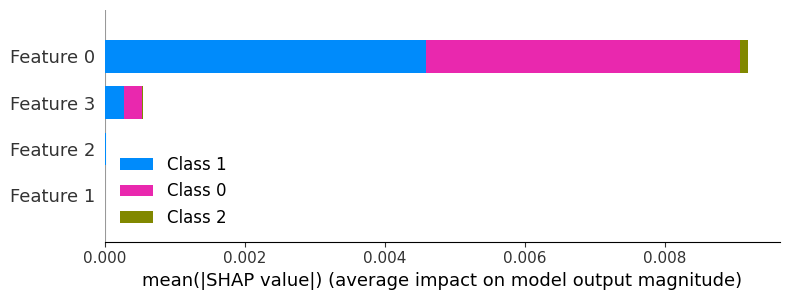

In [24]:
import shap
import numpy as np

print("Computing SHAP with wrapped model...")

# Combine numeric + categorical inputs into one array for SHAP
def model_wrapper(X):
    # Split back into num and cat parts for model prediction
    n_num = X_num_train.shape[1]
    num = X[:, :n_num]
    cat = X[:, n_num:].astype(np.int32)
    return model({'num': num, 'cat': cat}).numpy()

# Prepare background and explanation samples
bg_n = min(200, len(X_num_train))
bg_idx = np.random.choice(len(X_num_train), bg_n, replace=False)
expl_idx = np.random.choice(len(X_num_train), min(200, len(X_num_train)), replace=False)

# Concatenate numeric + categorical into one array
X_bg = np.concatenate([X_num_train[bg_idx], X_cat_train[bg_idx]], axis=1)
X_expl = np.concatenate([X_num_train[expl_idx], X_cat_train[expl_idx]], axis=1)

# Create SHAP explainer on the wrapper
explainer = shap.Explainer(model_wrapper, X_bg)

# Compute SHAP values
shap_values = explainer(X_expl)

# Plot
shap.summary_plot(shap_values, show=True)

In [26]:
# Save final submission
sub = sample_submission.copy()
id_col = sub.columns[0]
target_cols = sub.columns.tolist()[1:]

# Ensure the submission DataFrame has the same index as the test data
sub = pd.DataFrame({id_col: test[id_col]})

if problem_type == 'multiclass':
    # Assuming test_final predictions are in the same order as test dataframe
    if len(target_cols) == test_final.shape[1]:
        for i,col in enumerate(target_cols):
            sub[col] = test_final[:, i]
    else:
        # If target columns in sample submission don't match prediction shape,
        # assume it's a single target column and use argmax for multiclass
        sub[target_cols[0]] = np.argmax(test_final, axis=1)
else:
    sub[target_cols[0]] = test_final
out_name = 'submission_tf_full_complete.csv'
sub.to_csv(out_name, index=False)
print('Saved', out_name)

Saved submission_tf_full_complete.csv


In [27]:
# ============================================================
# 🔍 Model Evaluation / Testing Cell
# ============================================================

import numpy as np
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, log_loss

print("🔍 Evaluating model performance...")

# ---------------------------
# 1️⃣  Predict on validation or training data
# ---------------------------
# (Here we'll predict on all training data for quick inspection)
y_pred = model.predict({'num': X_num_train, 'cat': X_cat_train}, batch_size=512, verbose=1)

# ---------------------------
# 2️⃣  Evaluate based on problem type
# ---------------------------
if problem_type == "regression":
    rmse = mean_squared_error(y, y_pred, squared=False)
    print(f"✅ RMSE: {rmse:.5f}")

elif problem_type == "binary":
    auc = roc_auc_score(y, y_pred)
    acc = accuracy_score(y, (y_pred > 0.5).astype(int))
    print(f"✅ AUC: {auc:.5f} | ACC: {acc:.5f}")

elif problem_type == "multiclass":
    y_pred_probs = y_pred
    y_pred_labels = np.argmax(y_pred_probs, axis=1)
    acc = accuracy_score(y, y_pred_labels)
    loss = log_loss(y, y_pred_probs)
    print(f"✅ LogLoss: {loss:.5f} | ACC: {acc:.5f}")

# ---------------------------
# 3️⃣  Optional: Predict on test set and preview
# ---------------------------
test_pred = model.predict({'num': X_num_test, 'cat': X_cat_test}, batch_size=512, verbose=1)

print("\n🧾 Test prediction preview:")
print(test_pred[:10].flatten() if test_pred.ndim == 2 else test_pred[:10])

🔍 Evaluating model performance...
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step
✅ LogLoss: 0.71301 | ACC: 0.53746
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step

🧾 Test prediction preview:
[0.55971295 0.4367438  0.00354327 0.55971295 0.43674383 0.00354327
 0.5597129  0.4367439  0.00354327 0.5597128  0.43674394 0.00354327
 0.5597127  0.43674397 0.00354327 0.55971265 0.43674394 0.00354327
 0.55971265 0.4367441  0.00354326 0.55971265 0.43674412 0.00354326
 0.5597125  0.4367442  0.00354326 0.5597125  0.43674424 0.00354326]
